# Imports

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt

import copy, cv2, os, time, pickle, collections
import numpy as np
from random import shuffle
from io import StringIO
import PIL.Image as Image
from tqdm import tqdm
import PIL.ImageColor as ImageColor
import PIL.ImageDraw as ImageDraw
import PIL.ImageFont as ImageFont
from IPython.display import display

# Import the necessary keras layers and utils for modeling
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Reshape, Lambda, Conv2D, MaxPooling2D, ZeroPadding2D, ReLU, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16 
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

# Import helpfull training utils
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint

# Config

In [3]:
# This is for the orientation estimation. (values are from the original paper)
BIN, OVERLAP = 2, 0.1

W = 1.
# The crop shapes for the input 3D network.
NORM_H, NORM_W = 224, 224

# Maximum bounding box jitter for data augmentation while training 3D network
MAX_JIT=3

# Classes to be considered and extracted from kitti dataset, while training the 3D network
VEHICLES = ["Car", "Truck", "Cyclist", "Pedestrian"]

# These are used to filter out useless and bad objects from dataset (for training)
MAX_OCCLUSION =1 # anything <= will be included.
MAX_TRUNCATION = 0.8 # anything < will be included.

# Path to the images and labels dir.
image_dir = r'G:\My Drive\deep box\data\data_object_image_2\training\image_2'
label_dir = r'G:\My Drive\deep box\data\training\label_2'

FEATURE_EXTRACTOR_3D = 'mobilenetv2' #OR vgg16

STANDARD_COLORS = ['AliceBlue', 'Chartreuse', 'Aqua', 'Aquamarine', 'Azure', 'Beige']

category_index = {1: {'id': 1, 'name': 'car'}, 2: {'id': 2, 'name': 'pedestrian'}, 
                  4: {'id': 4, 'name': 'truck'}, 3: {'id': 3, 'name': 'cyclist'}}

# Utils

In [4]:
class Utils:
    """
    This class groups a couple of functions for data processing, visualisation and model building
    """
    ############################################ DATA PROCESSING UTILS ############################################
    def compute_anchors(angle):
        anchors = []

        wedge = 2.*np.pi/BIN  #Length of each bin in Radian.

        # Each angle will lie somewhere in a bin. But we need to find the closest. 
        # That is, given a bin, we want to know which bound is closer to our angle.
        # For instance if our bin is (pi/2, pi), we want to know whether the angle is easier to reference from pi/2 or pi.
        # So we keep both lower and upper bound using l_index and r_index, respectively.
        l_index = int(angle/wedge)
        r_index = l_index + 1

        # If close enough to the lower bound, consider current index
        if (angle - l_index * wedge) < wedge/2 * (1 + OVERLAP/2):
            anchors.append([l_index, angle - l_index*wedge])
            
        if (r_index * wedge - angle) < wedge/2 * (1 + OVERLAP/2):
            anchors.append([r_index % BIN, angle - r_index*wedge])

        return anchors

    def _prepare_input_and_output(train_inst):

        # Read the image.
        img = cv2.imread(f"{image_dir}{train_inst['image']}")

        # Read each bounding box
        xmin = train_inst['xmin']
        ymin = train_inst['ymin']
        xmax = train_inst['xmax']
        ymax = train_inst['ymax']

        # Crop the frame.
        img = copy.deepcopy(img[ymin:ymax+1,xmin:xmax+1]).astype(np.float32)

        # Randomly decide whether to flip or not.
        flip = np.random.binomial(1, .5)
        if flip > 0.5: 
            img = cv2.flip(img, 1)

        # resize the patch to standard size
        img = cv2.resize(img, (NORM_H, NORM_W))

        # Make pixel values [-0.5 to 0.5].
        img = (img - np.array([[[103.939, 116.779, 123.68]]])) / 255.

        #Return data but take care of returining proper orientation.
        if flip > 0.5:
            return img, train_inst['dims'], train_inst['orient_flipped'], train_inst['conf_flipped']
        else:
            return img, train_inst['dims'], train_inst['orient'], train_inst['conf']
    
    def data_gen(all_objs, batch_size):

        num_obj = len(all_objs)

        keys = list(range(num_obj))
        np.random.shuffle(list(keys))

        # For each batch, we will have indices of [ l_bound ...... r_bound ) (not including r_bound itself).
        # Usually r_bound - l_bound  should be equal to batch size.
        l_bound = 0
        r_bound = batch_size if batch_size < num_obj else num_obj

        while True:
            if l_bound == r_bound:
                l_bound  = 0
                r_bound = batch_size if batch_size < num_obj else num_obj
                np.random.shuffle(list(keys))

            currt_inst = 0
            x_batch = np.zeros((r_bound - l_bound, 224, 224, 3)) # Image batch
            d_batch = np.zeros((r_bound - l_bound, 3)) # Dimension batch
            o_batch = np.zeros((r_bound - l_bound, BIN, 2)) # orientation batch
            c_batch = np.zeros((r_bound - l_bound, BIN)) # confidences batch

            # Iterate the batch
            for key in keys[l_bound:r_bound]:
                
                # Prepare the data for the current frame.
                image, dimension, orientation, confidence = Utils._prepare_input_and_output(all_objs[key])

                x_batch[currt_inst, :] = image
                d_batch[currt_inst, :] = dimension
                o_batch[currt_inst, :] = orientation
                c_batch[currt_inst, :] = confidence

                currt_inst += 1

            # Yield the prepared batch. 
            yield x_batch, [d_batch, o_batch, c_batch]

            # Go for the next batch
            l_bound  = r_bound
            r_bound = r_bound + batch_size

            # Limit the r_bount to max valid index.
            if r_bound > num_obj: 
                r_bound = num_obj 
    
    def parse_annotation(label_dir, image_dir):
        # Here we prepare all objects (patches), their attributes, and the
        # average dimension across the dataset.
        all_objs = []

        # The average vector and the object count used for averaging.
        dims_avg = {key:np.array([0, 0, 0]) for key in VEHICLES}
        dims_cnt = {key:0 for key in VEHICLES}

        # Iterate through label files.
        for label_file in os.listdir(label_dir):

            image_file = label_file.replace('txt', 'png')

            # Iterate through lines in each label file
            for line in open(label_dir + label_file).readlines():
                line = line.strip().split(' ')
                
                # Each row will have this structure:
                # Class Truncated Occluded Theta(local) Xmin Ymin Xmax Ymax Dim Dim Dim T T T 
                truncated = np.abs(float(line[1]))
                occluded  = np.abs(float(line[2]))

                # Make sure it is a relevant class and with enough visibility (based on global parameters)
                if line[0] in VEHICLES and truncated < MAX_TRUNCATION and occluded <= MAX_OCCLUSION:

                    new_alpha = -float(line[3]) + 3*np.pi/2
                    new_alpha = new_alpha - np.floor(new_alpha / (2. * np.pi)) * (2. * np.pi)

                    obj = {'name':line[0],
                           'image':image_file,
                           'xmin':int(float(line[4])),
                           'ymin':int(float(line[5])),
                           'xmax':int(float(line[6])),
                           'ymax':int(float(line[7])),
                           'dims':np.array([float(number) for number in line[8:11]]),
                           'new_alpha': new_alpha, 
                           # The next 3 are not used for training the network, but for benchmarking translation vector accuracy. 
                           'translation':np.array([float(number) for number in line[11:14]]),
                           'truncated': truncated,
                           'occluded': occluded
                          }

                    # Update the average while reading the new object's dimensions
                    dims_avg[obj['name']]  = dims_cnt[obj['name']] * dims_avg[obj['name']] + obj['dims']
                    dims_cnt[obj['name']] += 1
                    dims_avg[obj['name']] /= dims_cnt[obj['name']]

                    # Add the object to the list
                    all_objs.append(obj)

        return all_objs, dims_avg
    ############################################ MODELING UTILS ############################################    
    def l2_normalize(x):
        # Compute the second norm for each (sin, cos) pair and normalize the values.
        # So (sin, cos) will be normalized into (sin/sqrt(sin^2+cos^2) , cos/sqrt(sin^2+cos^2)).
        # Thus if the network gives (a,b), we are always sure that a^2 + b^2 = 1 and we can use arctan with no worries.
        return tf.math.l2_normalize(x, axis=2)
    
    def orientation_loss(y_true, y_pred):
        # Here we have two 3D arrays with shape (batch_size, bin count, 2). the 2 is for the (sin, cos) vector.
        # The loss value, however, should be a scalar.

        # Make (sin, cos) into (sin^2, cos^2) and then sum them up into 1 scalar.
        # So the shape is now (batch_size, bin_count)
        anchors = tf.reduce_sum(tf.square(y_true), axis=2)

        # Assigns true for every bin that has enough overlap with the true angle.
        anchors = tf.greater(anchors, tf.constant(0.5))

        # Now for each row, sum the values. So the shape is now (batch size).
        anchors = tf.reduce_sum(tf.cast(anchors, tf.float32), 1)

        # Cosine similarity for the loss. 
        # We compute  cos(alpha)= a.b / |a||b|. 
        # alpha is the angle between ground truth vector and the estimation.
        # The ideal value would be cos(0) = 1. But gradient decent tries to MINIMIZE the loss.
        # So we add a (-) sign. Now the ideal loss value is -1 and the network gets trained in the right direction.
        loss = -(y_true[:,:,0] * y_pred[:,:,0] + y_true[:,:,1] * y_pred[:,:,1]) 

        # For each batch, sum all loss values for all bins. So the shape becomes (batch size)
        loss = tf.reduce_sum(loss, axis=1)

        # Normalize the loss.
        loss = loss / anchors

        # Use mean to turn the vector loss into scalar.
        return tf.reduce_mean(loss)
    
    def load_2D_model(model_path):
        model = tf.saved_model.load(model_path)
        return model
    
    def _run_inference_for_single_image(model, image):
        image = np.asarray(image)
        
        # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
        input_tensor = tf.convert_to_tensor(image)
        # The model expects a batch of images, so add an axis with `tf.newaxis`.
        input_tensor = input_tensor[tf.newaxis,...]

        # Run inference
        model_fn = model.signatures['serving_default']
        output_dict = model_fn(input_tensor)

        # All outputs are batches tensors.
        # Convert to numpy arrays, and take index [0] to remove the batch dimension.
        # We're only interested in the first num_detections.
        num_detections = int(output_dict.pop('num_detections'))
        output_dict = {key:value[0, :num_detections].numpy() for key,value in output_dict.items()}
        output_dict['num_detections'] = num_detections

        # detection_classes should be ints.
        output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)

        # Handle models with masks:
        if 'detection_masks' in output_dict:
            # Reframe the bbox mask to the image size.
            detection_masks_reframed = Utils._reframe_box_masks_to_image_masks(output_dict['detection_masks'], 
                                                                               output_dict['detection_boxes'],
                                                                               image.shape[0], image.shape[1])      
            detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,tf.uint8)
            output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()

        return output_dict
    
    def show_2d_inference(model, image_path):
        # the array based representation of the image will be used later in order to prepare the
        # result image with boxes and labels on it.
        image_np = np.array(Image.open(image_path))
        # Actual detection.
        output_dict = Utils._run_inference_for_single_image(model, image_np)
        # Visualization of the results of a detection.
        Utils._visualize_boxes_and_labels_on_image_array(
          image_np,
          output_dict['detection_boxes'],
          output_dict['detection_classes'],
          output_dict['detection_scores'],
          category_index,
          instance_masks=output_dict.get('detection_masks_reframed', None),
          use_normalized_coordinates=True,
          line_thickness=3)

        display(Image.fromarray(image_np))
        
    def get_2D_detection(model, image_path):
        # the array based representation of the image will be used later in order to prepare the
        # result image with boxes and labels on it.
        image_np = np.array(Image.open(image_path))
        image = np.asarray(image_np)
        im_height, im_width, _ = image.shape
        # Actual detection.
        output_dict = Utils._run_inference_for_single_image(model, image_np)
        boxes = []
        for j in output_dict['detection_boxes']:
            ymin, xmin, ymax, xmax = j
            boxes.append([round(xmin* im_width), round(ymin*im_height), round(xmax*im_width), round(ymax*im_height)])
        return np.asarray(boxes), output_dict['detection_classes'], output_dict['detection_scores']
    
    ############################################ VISUALIZATION UTILS ############################################   
    def init_points3D(dims):
        points3D = np.zeros((8, 3))
        cnt = 0
        for i in [1, -1]:
            for j in [1, -1]:
                for k in [1, -1]:
                    points3D[cnt] = dims[[1, 0, 2]].T / 2.0 * [i, k, j * i]
                    cnt += 1
        return points3D
    
    def gen_3D_box(yaw, dims, cam_to_img, box_2D,inds):
        dims = dims.reshape((-1,1))
        box_2D = box_2D.reshape((-1,1))
        points3D = Utils.init_points3D(dims)

        # Here the rotation is done around the Y axis. Just a convention in the code.
        rot_M = np.asarray([[np.cos(yaw), 0, np.sin(yaw)], [0, 1, 0], [-np.sin(yaw), 0, np.cos(yaw)]]) 
        center = Utils.compute_center(points3D, rot_M, cam_to_img, box_2D, inds)

        points2D = Utils.points3D_to_2D(points3D, center, rot_M, cam_to_img)

        return points2D

    def compute_center(points3D, rot_M, cam_to_img, box_2D, inds):
        fx = cam_to_img[0][0]
        fy = cam_to_img[1][1]
        u0 = cam_to_img[0][2]
        v0 = cam_to_img[1][2]

        W = np.array([[fx, 0, u0 - box_2D[0]],
                      [fx, 0, u0 - box_2D[2]],
                      [0, fy, v0 - box_2D[1]],
                      [0, fy, v0 - box_2D[3]]], dtype = 'float')
        center = None
        error_min = 1e10

        for ind in inds:
            y = np.zeros((4, 1))
            for i in range(len(ind)):
                RP = np.dot(rot_M, (points3D[ind[i]]).reshape((-1, 1)))
                y[i] = box_2D[i] * cam_to_img[2, 3] - np.dot(W[i], RP) - cam_to_img[i // 2, 3]

            result = Utils.solve_least_square(W, y)
            error = Utils.compute_error(points3D, result, rot_M, cam_to_img, box_2D)

            if error < error_min and result[2,0]>0:
                center = result
                error_min = error

        return center
    
    def solve_least_square(W, y):
        u, sigma, vt = np.linalg.svd(W)
        return np.dot(np.dot(np.dot(vt.T, np.linalg.pinv(np.eye(4, 3) * sigma)), u.T), y)
    
    def draw_3D_box(image, points, color):
        points = points.astype(np.int)
        for i in range(4):
            point_1_ = points[2 * i]
            point_2_ = points[2 * i + 1]
            cv2.line(image, (point_1_[0], point_1_[1]), (point_2_[0], point_2_[1]), color, 1)

        # The red X at the front.
        cv2.line(image,tuple(points[0]),tuple(points[7]),(0, 0, 255), 2)
        cv2.line(image, tuple(points[1]), tuple(points[6]), (0, 0, 255), 2)

        for i in range(8):
            point_1_ = points[i]
            point_2_ = points[(i + 2) % 8]
            cv2.line(image, (point_1_[0], point_1_[1]), (point_2_[0], point_2_[1]), color, 1)

        return image
    
    def points3D_to_2D(points3D, center, rot_M, cam_to_img):
        # General formula is: [2D] = K[R T][3D]
        # So for each 3D point, apply rotation, add translation (3D center)
        # and multiply K. At last, you will have a 3x1 vector, which you should normalize
        # by the third element.
        points2D = []
        for point3D in points3D:
            point3D = point3D.reshape((-1,1))
            point = center + np.dot(rot_M, point3D)
            point = np.append(point, 1)
            point = np.dot(cam_to_img, point)
            point2D = point[:2] / point[2]
            points2D.append(point2D)
        points2D = np.asarray(points2D)

        return points2D
    
    def compute_error(points3D, center, rot_M, cam_to_img, box_2D):
        # Get all of 8 corners from 3D box projected on image.
        points2D = Utils.points3D_to_2D(points3D, center, rot_M, cam_to_img)

        # Get a new bounding box from the 8 projected coreners.
        new_box_2D = np.asarray([np.min(points2D[:,0]),
                                 np.max(points2D[:,0]),
                                 np.min(points2D[:,1]),
                                 np.max(points2D[:,1])]).reshape((-1,1))

        # Sum the absolute difference of xmin, xmax, ymin, ymax for the 2D bbox,
        # and the new bbox from 8 projections.
        error = np.sum(np.abs(new_box_2D - box_2D))
        return error
    
    def _get_patches_from_txt(image_plot, label_path):
        patches = []
        final_boxes = []
        labels = []
        for line in open(label_path).readlines():
            line = line.strip().split(' ')

            xmin=int(float(line[4]))
            ymin=int(float(line[5]))
            xmax=int(float(line[6]))
            ymax=int(float(line[7]))

            patch = image_plot[ymin:ymax, xmin:xmax]
            patch = cv2.resize(patch, (224, 224))
            patches.append(patch)
            final_boxes.append((xmin, ymin, xmax, ymax))
            labels.append(line[0])

        num_patches = len(patches)
        fig = plt.figure(figsize=(15, 15))

        for index, patch in enumerate(patches):
            fig.add_subplot(1, num_patches, index+1)
            plt.imshow(patch)

        plt.show()
        return patches, final_boxes, labels
    
    def _get_patches_from_2d_pred(image_plot, pred):
            patches = []
            final_boxes = []
            labels = []

            for i in range(len(pred[0])):
                xmin, ymin, xmax, ymax = pred[0][i]
                patch = image_plot[ymin:ymax, xmin:xmax]
                patch = cv2.resize(patch, (224, 224))
                patch = patch / 255.0 - 0.5
                if pred[2][i] > 0.9:
                    patches.append(patch)
                    final_boxes.append((xmin, ymin, xmax, ymax))
                    labels.append(pred[1][i])

            return patches, final_boxes, labels
    
    def _get_calib_matrix(calib_path):
        with open(calib_path, "r") as f:
            c2c_file = f.readlines()
            for line in c2c_file:
                (key, val) = line.split(':', 1)
                if key == ('P2'):
                    P_ = np.fromstring(val, sep=' ', dtype = 'float')
                    P_ = P_.reshape(3, 4)
                    calib_mat = P_
                    break
        return calib_mat
    
    def _gen_inds_and_avg_dims():
        inds = []
        indx = [1, 3, 5, 7]
        indy = [0, 1, 2, 3]
        for i in indx:
            for j in indx:
                for m in indy:
                    for n in indy:
                        inds.append([i, j, m, n])
        # Dimension averages collected from the dataset
        dims_avg = {'car': [1.52592569, 1.63330135, 3.8924114], 
                    'truck': [ 3.21223545,  2.59305556, 10.61243386], 
                    'cyclist': [1.73227675, 0.5971601 , 1.77189863], 
                    'pedestrian': [1.76037403, 0.66302698, 0.86203313]}
        return inds, dims_avg
    
    def _get_t(yaw,dims,cam_to_img,box_2D, ind):
        dims = dims.reshape((-1,1))
        box_2D = box_2D.reshape((-1,1))
        points3D = init_points3D(dims)
        rot_M = np.asarray([[np.cos(yaw), 0, np.sin(yaw)], [0, 1, 0], [-np.sin(yaw), 0, np.cos(yaw)]]) 
        center = Utils.compute_center(points3D, rot_M, cam_to_img, box_2D, inds)
        return center

    def _compare_t(estimated_t, true_t):
        estimated = np.asarray([float(estimated_t[0]), float(estimated_t[1]), float(estimated_t[2])])
        dist = np.linalg.norm(true_t - estimated)
        normalized_dist  = np.linalg.norm(true_t - estimated) / np.linalg.norm(true_t)
        return dist, normalized_dist
    
    def evaluate_translation(all_objs, trv_split, all_exams, calib_path, train_images_path, model):
        avg_t_loss=0
        avg_nt_loss=0
        cnt = 0
        for obj in all_objs[trv_split:all_exams]:
            truncated = obj['truncated']
            occluded = obj['occluded']
            height = int(obj['ymax'] - obj['ymin'])
            width = int(obj['xmax'] - obj['xmin'])
            # Filter based on occlusion and trunction.
            # Many objects' centers are not even in front of the camera
            if (truncated > 0.5 or occluded> 1 or height <=25 or width <=25):
                continue
                
            calib_mat = Utils._get_calib_matrix(calib_path + obj['image'].split('.')[0]+'.txt')

            xmin = int(obj['xmin'])
            ymin = int(obj['ymin'])
            xmax = int(obj['xmax'])
            ymax = int(obj['ymax'])

            test_image = cv2.imread(train_images_path + obj['image'])
            patch = test_image[ymin:ymax, xmin:xmax]
            patch = cv2.resize(patch, (224, 224))
            patch = patch / 255.0 - 0.5

            patch = np.expand_dims(patch, axis = 0)

            prediction = model.predict(patch)
            max_anc = np.argmax(prediction[2][0])
            anchors = prediction[1][0][max_anc]

            if anchors[1] > 0:
                angle_offset = np.arccos(anchors[0])
            else:
                angle_offset = -np.arccos(anchors[0])

            wedge = 2. * np.pi/BIN
            theta_loc = angle_offset + max_anc*wedge
            fx = calib_mat[0][0]
            u0 = calib_mat[0][2]
            v0 = calib_mat[1][2]

            box2d_center_x= (xmin + xmax) / 2.0

            theta_ray = np.arctan(fx /(box2d_center_x - u0))
            if theta_ray<0:
                  theta_ray = theta_ray+np.pi

            # Theta Yaw
            theta = theta_loc + theta_ray
            yaw = np.pi/2 - theta
            
            inds, dims_avg = Utils._gen_inds_and_avg_dims()

            dims = dims_avg[obj['name']] + prediction[0][0]

            box_2D = np.asarray([xmin, ymin, xmax, ymax], dtype = np.float)
            points2D = Utils.gen_3D_box(yaw, dims, calib_mat, box_2D) #switched yaw -> theta
            final_image = Utils.draw_3D_box(test_image, points2D)

            t = Utils._get_t(yaw, dims, calib_mat, box_2D, inds) #switched yaw -> theta    
            t_loss, nt_loss = Utils._compare_t(t, obj['translation'])
            cnt += 1
            avg_t_loss = ( (avg_t_loss * (cnt-1)) + t_loss )/cnt
            avg_nt_loss = ( (avg_nt_loss * (cnt-1)) + nt_loss )/cnt

        return avg_t_loss, avg_nt,loss, cnt
    
    def visualize3D(model, image_path, calib_path, label_path):
        test_image = cv2.imread(image_path)
        test_image = test_image[:, :, ::-1] # BGR TO RGB
        patches, final_boxes, labels = Utils._get_patches_from_txt(test_image, label_path)
        calib_mat = Utils._get_calib_matrix(calib_path)
        inds,dims_avg = Utils._gen_inds_and_avg_dims()
        final_image = test_image.copy()
        for index, box in enumerate(final_boxes):
            xmin, ymin, xmax, ymax = box
            
            # Crop
            patch = test_image[ymin:ymax, xmin:xmax]
            
            # Resize
            patch = cv2.resize(patch, (224, 224))
            
            # Set the input pixels to be within (-0.5 , 0.5).
            patch = patch / 255.0 - 0.5

            patch = np.expand_dims(patch, axis = 0)
            prediction = model.predict(patch)
            
            # Get the (cos, sin) of the bin with highest probabilitys
            max_anc = np.argmax(prediction[2][0])
            anchors = prediction[1][0][max_anc]

            # anchors=(cos, sin)
            if anchors[1] > 0:
                angle_offset = np.arccos(anchors[0])
            else:
                angle_offset = -np.arccos(anchors[0])

            wedge = 2.*np.pi/BIN
            theta_loc = angle_offset + max_anc*wedge

            fx = calib_mat[0][0]
            u0 = calib_mat[0][2]
            v0 = calib_mat[1][2]

            # As suggested in the original paper, we estimate the raye to 2D box center instead of
            # object's 3D center. Of course, it is not entirely accurate, but it is sufficient.
            box2d_center_x= (xmin + xmax) / 2.0
            theta_ray = np.arctan(fx /(box2d_center_x - u0))
            
            # Arctan's output is (-pi/2, pi/2). But theta_ray should be (0, pi).
            # From 0 to pi/2 the values are ok but if the object's center is on the left half,
            # the arctan will result in a negative theta_ray. This can be fixed by adding pi.
            if theta_ray<0:
                  theta_ray = theta_ray+np.pi

            # Final theta
            theta = theta_loc + theta_ray
            yaw = np.pi/2 - theta

            dims = np.array(dims_avg[labels[index]]) + prediction[0][0]

            box_2D = np.asarray([box[0], box[1], box[2], box[3]], dtype = np.float)
            points2D = Utils.gen_3D_box(yaw, dims, calib_mat, box_2D) #switched yaw -> theta  
            final_image = Utils.draw_3D_box(final_image, points2D)

        plt.figure(figsize=(20,20))
        plt.imshow(final_image_show/255.)
        plt.show()
        
    def visualize_final_3D(model, image_path, calib_path, pred_2d):
        test_image = cv2.imread(image_path)
        test_image = test_image[:, :, ::-1] # BGR TO RGB
        
        patches, final_boxes, labels = Utils._get_patches_from_2d_pred(test_image, pred_2d)
        calib_mat = Utils._get_calib_matrix(calib_path)
        inds,dims_avg = Utils._gen_inds_and_avg_dims()
        final_image = test_image.copy()
        for index, box in enumerate(final_boxes):
            xmin, ymin, xmax, ymax = box
            
            # Crop
            patch = test_image[ymin:ymax, xmin:xmax]
            
            # Resize
            patch = cv2.resize(patch, (224, 224))
            
            # Set the input pixels to be within (-0.5 , 0.5).
            patch = patch / 255.0 - 0.5

            patch = np.expand_dims(patch, axis = 0)
            prediction = model.predict(patch)
            
            # Get the (cos, sin) of the bin with highest probabilitys
            max_anc = np.argmax(prediction[2][0])
            anchors = prediction[1][0][max_anc]

            # anchors=(cos, sin)
            if anchors[1] > 0:
                angle_offset = np.arccos(anchors[0])
            else:
                angle_offset = -np.arccos(anchors[0])

            wedge = 2.*np.pi/BIN
            theta_loc = angle_offset + max_anc*wedge

            fx = calib_mat[0][0]
            u0 = calib_mat[0][2]
            v0 = calib_mat[1][2]

            # As suggested in the original paper, we estimate the raye to 2D box center instead of
            # object's 3D center. Of course, it is not entirely accurate, but it is sufficient.
            box2d_center_x= (xmin + xmax) / 2.0
            theta_ray = np.arctan(fx /(box2d_center_x - u0))
            
            # Arctan's output is (-pi/2, pi/2). But theta_ray should be (0, pi).
            # From 0 to pi/2 the values are ok but if the object's center is on the left half,
            # the arctan will result in a negative theta_ray. This can be fixed by adding pi.
            if theta_ray<0:
                  theta_ray = theta_ray+np.pi

            # Final theta
            theta = theta_loc + theta_ray
            yaw = np.pi/2 - theta

            dims = np.array(dims_avg[category_index[labels[index]]["name"]]) + prediction[0][0]

            box_2D = np.asarray([box[0], box[1], box[2], box[3]], dtype = np.float)
            points2D = Utils.gen_3D_box(yaw, dims, calib_mat, box_2D,inds) #switched yaw -> theta  
            final_image = Utils.draw_3D_box(final_image, points2D, (0,255,0))

        plt.figure(figsize=(20,20))
        plt.imshow(final_image/255.)
        plt.show()
        
    def write_final_3D(model, image_path, calib_path, pred_2d,output_file,save_to_disk=False):
        test_image = cv2.imread(image_path)
        test_image = test_image[:, :, ::-1] # BGR TO RGB
        patches, final_boxes, labels = Utils._get_patches_from_2d_pred(test_image, pred_2d)
        calib_mat = Utils._get_calib_matrix(calib_path)
        inds,dims_avg = Utils._gen_inds_and_avg_dims()
        final_image = test_image.copy()
        for index, box in enumerate(final_boxes):
            xmin, ymin, xmax, ymax = box
            
            # Crop
            patch = test_image[ymin:ymax, xmin:xmax]
            
            # Resize
            patch = cv2.resize(patch, (224, 224))
            
            # Set the input pixels to be within (-0.5 , 0.5).
            patch = patch / 255.0 - 0.5

            patch = np.expand_dims(patch, axis = 0)
            prediction = model.predict(patch)
            
            # Get the (cos, sin) of the bin with highest probabilitys
            max_anc = np.argmax(prediction[2][0])
            anchors = prediction[1][0][max_anc]

            # anchors=(cos, sin)
            if anchors[1] > 0:
                angle_offset = np.arccos(anchors[0])
            else:
                angle_offset = -np.arccos(anchors[0])

            wedge = 2.*np.pi/BIN
            theta_loc = angle_offset + max_anc*wedge

            fx = calib_mat[0][0]
            u0 = calib_mat[0][2]
            v0 = calib_mat[1][2]

            # As suggested in the original paper, we estimate the raye to 2D box center instead of
            # object's 3D center. Of course, it is not entirely accurate, but it is sufficient.
            box2d_center_x= (xmin + xmax) / 2.0
            theta_ray = np.arctan(fx /(box2d_center_x - u0))
            
            # Arctan's output is (-pi/2, pi/2). But theta_ray should be (0, pi).
            # From 0 to pi/2 the values are ok but if the object's center is on the left half,
            # the arctan will result in a negative theta_ray. This can be fixed by adding pi.
            if theta_ray<0:
                  theta_ray = theta_ray+np.pi

            # Final theta
            theta = theta_loc + theta_ray
            yaw = np.pi/2 - theta

            dims = np.array(dims_avg[category_index[labels[index]]["name"]]) + prediction[0][0]

            box_2D = np.asarray([box[0], box[1], box[2], box[3]], dtype = np.float)
            points2D = Utils.gen_3D_box(yaw, dims, calib_mat, box_2D,inds) #switched yaw -> theta  
            final_image = Utils.draw_3D_box(final_image, points2D, (0,255,0))
        final_image = cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB)
        if save_to_disk:
            cv2.imwrite(output_file,final_image)
        return final_image
        
        
    def _draw_mask_on_image_array(image, mask, color='red', alpha=0.4):
        if image.dtype != np.uint8:
            raise ValueError('`image` not of type np.uint8')
        if mask.dtype != np.uint8:
            raise ValueError('`mask` not of type np.uint8')
        if np.any(np.logical_and(mask != 1, mask != 0)):
            raise ValueError('`mask` elements should be in [0, 1]')
        if image.shape[:2] != mask.shape:
            raise ValueError(f'The image has spatial dimensions {image.shape[:2]} but the mask has dimensions {mask.shape}')
        rgb = ImageColor.getrgb(color)
        pil_image = Image.fromarray(image)

        solid_color = np.expand_dims(np.ones_like(mask), axis=2) * np.reshape(list(rgb), [1, 1, 3])
        pil_solid_color = Image.fromarray(np.uint8(solid_color)).convert('RGBA')
        pil_mask = Image.fromarray(np.uint8(255.0 * alpha * mask)).convert('L')
        pil_image = Image.composite(pil_solid_color, pil_image, pil_mask)
        np.copyto(image, np.array(pil_image.convert('RGB')))
    
    def _draw_bounding_box_on_image_array(image,ymin,xmin,ymax,xmax,color='red',thickness=4,display_str_list=(),use_normalized_coordinates=True):
        image_pil = Image.fromarray(np.uint8(image)).convert('RGB')
        Utils._draw_bounding_box_on_image(image_pil, ymin, xmin, ymax, xmax, color,thickness, display_str_list,use_normalized_coordinates)
        np.copyto(image, np.array(image_pil))
        
    def _draw_bounding_box_on_image(image,ymin,xmin,ymax,xmax,color='red',thickness=4,display_str_list=(),use_normalized_coordinates=True):
        draw = ImageDraw.Draw(image)
        im_width, im_height = image.size
        if use_normalized_coordinates:
            (left, right, top, bottom) = (xmin * im_width, xmax * im_width, ymin * im_height, ymax * im_height)
        else:
            (left, right, top, bottom) = (xmin, xmax, ymin, ymax)
        draw.line([(left, top), (left, bottom), (right, bottom), (right, top), (left, top)], width=thickness, fill=color)
        try:
            font = ImageFont.truetype('arial.ttf', 24)
        except IOError:
            font = ImageFont.load_default()

        # If the total height of the display strings added to the top of the bounding
        # box exceeds the top of the image, stack the strings below the bounding box
        # instead of above.
        display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
        # Each display_str has a top and bottom margin of 0.05x.
        total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

        if top > total_display_str_height:
            text_bottom = top
        else:
            text_bottom = bottom + total_display_str_height
        # Reverse list and print from bottom to top.
        for display_str in display_str_list[::-1]:
            text_width, text_height = font.getsize(display_str)
            margin = np.ceil(0.05 * text_height)
            draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                            (left + text_width, text_bottom)],
                           fill=color)
            draw.text((left + margin, text_bottom - text_height - margin),
                      display_str,
                      fill='black',
                      font=font)
            text_bottom -= text_height - 2 * margin
        
    def _visualize_boxes_and_labels_on_image_array(image,boxes,classes,scores,category_index,instance_masks=None,
                                                  use_normalized_coordinates=False,max_boxes_to_draw=20,
                                                  min_score_thresh=.8,agnostic_mode=False,line_thickness=4,
                                                  groundtruth_box_visualization_color='black',skip_scores=False,
                                                  skip_labels=False):

        box_to_display_str_map = collections.defaultdict(list)
        box_to_color_map = collections.defaultdict(str)
        box_to_instance_masks_map = {}
        if not max_boxes_to_draw:
            max_boxes_to_draw = boxes.shape[0]
        for i in range(min(max_boxes_to_draw, boxes.shape[0])):
            if scores is None or scores[i] > min_score_thresh:
                box = tuple(boxes[i].tolist())
                if instance_masks is not None:
                    box_to_instance_masks_map[box] = instance_masks[i]
                if scores is None:
                    box_to_color_map[box] = groundtruth_box_visualization_color
                else:
                    display_str = ''
                    if not skip_labels:
                        if not agnostic_mode:
                            if classes[i] in category_index.keys():
                                class_name = category_index[classes[i]]['name']
                            else:
                                class_name = 'N/A'
                            display_str = str(class_name)
                    if not skip_scores:
                        if not display_str:
                            display_str = '{}%'.format(int(100 * scores[i]))
                        else:
                            display_str = '{}: {}%'.format(display_str, int(100 * scores[i]))
                            
                    box_to_display_str_map[box].append(display_str)
                    if agnostic_mode:
                        box_to_color_map[box] = 'DarkOrange'
                    else:
                        box_to_color_map[box] = STANDARD_COLORS[classes[i] % len(STANDARD_COLORS)]

        # Draw all boxes onto image.
        for box, color in box_to_color_map.items():
            ymin, xmin, ymax, xmax = box
            if instance_masks is not None:
                Utils._draw_mask_on_image_array(image, box_to_instance_masks_map[box], color=color)
            Utils._draw_bounding_box_on_image_array(image,ymin,xmin,ymax,xmax,color=color,thickness=line_thickness,display_str_list=box_to_display_str_map[box],use_normalized_coordinates=use_normalized_coordinates)

        return image

    def _reframe_box_masks_to_image_masks(box_masks, boxes, image_height, image_width, resize_method='bilinear'):
        resize_method = 'nearest' if box_masks.dtype == tf.uint8 else resize_method

        def reframe_box_masks_to_image_masks_default():
            num_boxes = tf.shape(box_masks)[0]
            box_masks_expanded = tf.expand_dims(box_masks, axis=3)

            resized_crops = tf.image.crop_and_resize(
                image=box_masks_expanded,
                boxes=reframe_image_corners_relative_to_boxes(boxes),
                box_ind=tf.range(num_boxes),
                crop_size=[image_height, image_width],
                method=resize_method,
                extrapolation_value=0)
            
            return tf.cast(resized_crops, box_masks.dtype)

        image_masks = tf.cond(tf.shape(box_masks)[0] > 0, reframe_box_masks_to_image_masks_default,
                              lambda: tf.zeros([0, image_height, image_width, 1], box_masks.dtype))
        return tf.squeeze(image_masks, axis=3)

# Data processing

In [ ]:
all_objs, dims_avg = Utils.parse_annotation(label_dir, image_dir)

print("number of objects: {}".format(len(all_objs)))
print(" ----- \n A sample object(patch):\n {} \n -----".format(all_objs[0]))
print("The average dimensions: {}".format(dims_avg))

for obj in all_objs:

    # Fix dimensions, compute the residual
    obj['dims'] = obj['dims'] - dims_avg[obj['name']]

    # Make all residuals 0
    orientation = np.zeros((BIN,2))
    # Make all bin confidences 0
    confidence = np.zeros(BIN)
    
    #turn angles into -> [bin# , residual]
    anchors = Utils.compute_anchors(obj['new_alpha'])
    
    for anchor in anchors:
        #compute the cosine and sine of the residual
        orientation[anchor[0]] = np.array([np.cos(anchor[1]), np.sin(anchor[1])])

        #make the confidence of relative bin# 1
        confidence[anchor[0]] = 1.
        
    #normalize confidences
    confidence = confidence / np.sum(confidence)
        
    #add the computed orientation and confidence to the obj
    obj['orient'] = orientation
    obj['conf'] = confidence
        
    # Fix orientation and confidence for flip
    orientation = np.zeros((BIN,2))
    confidence = np.zeros(BIN)
    
    anchors = Utils.compute_anchors(2. * np.pi - obj['new_alpha'])
    
    for anchor in anchors:
        orientation[anchor[0]] = np.array([np.cos(anchor[1]), np.sin(anchor[1])])
        confidence[anchor[0]] = 1
        
    confidence = confidence / np.sum(confidence)
        
    obj['orient_flipped'] = orientation
    obj['conf_flipped'] = confidence

# 3D model

In [5]:
# Construct the network
def build_model(feature_extractor, input_shape=(224, 224, 3), weights=None, freeze=False):

    if feature_extractor == 'mobilenetv2':
        feature_extractor_model = MobileNetV2(include_top=False, weights=weights, input_shape=input_shape)
    elif feature_extractor == 'vgg16':
        feature_extractor_model = VGG16(include_top=False, weights=weights, input_shape=input_shape)
    else:
        print("Requested a non-existing feature extractor model. Either choose from mobilenetv2 and vgg16 or add your own to the code")
        return
        
    if freeze:
        for layer in feature_extractor_model.layers:
            layer.trainable = False

    x = Flatten()(feature_extractor_model.output)

    dimension   = Dense(512)(x)
    dimension   = LeakyReLU(alpha=0.1)(dimension)
    dimension   = Dropout(0.5)(dimension)
    dimension   = Dense(3)(dimension)
    dimension   = LeakyReLU(alpha=0.1, name='dimension')(dimension)

    orientation = Dense(256)(x)
    orientation = LeakyReLU(alpha=0.1)(orientation)
    orientation = Dropout(0.5)(orientation)
    orientation = Dense(BIN*2)(orientation)
    orientation = LeakyReLU(alpha=0.1)(orientation)
    orientation = Reshape((BIN,-1))(orientation)
    orientation = Lambda(Utils.l2_normalize, name='orientation')(orientation)

    confidence  = Dense(256)(x)
    confidence  = LeakyReLU(alpha=0.1)(confidence)
    confidence  = Dropout(0.5)(confidence)
    confidence  = Dense(BIN, activation='softmax', name='confidence')(confidence)

    model = Model(feature_extractor_model.input, outputs=[dimension, orientation, confidence])
    

    return model 

In [6]:
model = build_model(input_shape = (224, 224, 3), weights = 'imagenet', freeze=True, feature_extractor=FEATURE_EXTRACTOR_3D)

today = time.localtime()
current_time = f"{today.tm_year}{today.tm_mon}{today.tm_mday}_{today.tm_hour}{today.tm_min}"
checkpoint_dir = os.path.join('checkpoints',current_time)
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = checkpoint_dir + '/saved_weights_mobilenet_transition.ckpt'

checkpoint  = ModelCheckpoint(checkpoint_path, monitor='val_loss',save_weights_only=False, verbose=1, save_best_only=True, mode='min', period=1)
early_stop  = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, mode='min', verbose=1)
tensorboard = TensorBoard(log_dir='logs', histogram_freq=0, write_graph=True, write_images=False)

all_exams  = len(all_objs)
trv_split  = int(0.85*all_exams)
batch_size = 8

np.random.shuffle(all_objs)

train_gen = Utils.data_gen(all_objs[:trv_split], batch_size)
valid_gen = Utils.data_gen(all_objs[trv_split:all_exams], batch_size)

train_num = int(np.ceil(trv_split/batch_size))
valid_num = int(np.ceil((all_exams - trv_split)/batch_size))

print("training configurations:")
print("all data:", all_exams)
print("training data:", trv_split)
print("batch size:", batch_size)
print("train_num", train_num)
print("valid_num", valid_num)


optim  = Adam(learning_rate=1e-4)
def decay_schedule(epoch, lr):
    if epoch in [15, 30, 45]:
        lr = lr * 0.1
    return lr

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(decay_schedule)
model.compile(optimizer=optim,
              loss={'dimension': 'mean_squared_error', 'orientation': Utils.orientation_loss, 'confidence': 'categorical_crossentropy'},
                  loss_weights={'dimension': 2., 'orientation': 1., 'confidence': 4.}, metrics=['mse','mae'])

training configurations:
all data: 1420
training data: 1207
batch size: 8
train_num 151
valid_num 27


In [13]:
model.fit(train_gen, 
          steps_per_epoch = train_num, 
          epochs = 50, 
          verbose = 1, 
          callbacks = [early_stop, checkpoint, tensorboard, lr_scheduler],
          validation_data = valid_gen, 
          validation_steps = valid_num
         )

C:\Users\Lenovo\.conda\envs\deepbox\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/50
2825/2825 [==============================] - 402s 139ms/step - loss: 1.5867 - dimension_loss: 0.4114 - orientation_loss: -0.8819 - confidence_loss: 0.4114 - dimension_mse: 0.4114 - dimension_mae: 0.3091 - orientation_mse: 0.3113 - orientation_mae: 0.3821 - confidence_mse: 0.1221 - confidence_mae: 0.2096 - val_loss: 1.0009 - val_dimension_loss: 0.3425 - val_orientation_loss: -0.8961 - val_confidence_loss: 0.3030 - val_dimension_mse: 0.3425 - val_dimension_mae: 0.2810 - val_orientation_mse: 0.3041 - val_orientation_mae: 0.3747 - val_confidence_mse: 0.0890 - val_confidence_mae: 0.1527

Epoch 00001: val_loss improved from inf to 1.00094, saving model to checkpoints\2021123_2123\saved_weights_mobilenet_transition.ckpt


C:\Users\Lenovo\.conda\envs\deepbox\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: checkpoints\2021123_2123\saved_weights_mobilenet_transition.ckpt\assets
Epoch 2/50
2825/2825 [==============================] - 385s 136ms/step - loss: 0.7263 - dimension_loss: 0.3745 - orientation_loss: -0.9059 - confidence_loss: 0.2208 - dimension_mse: 0.3745 - dimension_mae: 0.2800 - orientation_mse: 0.2985 - orientation_mae: 0.3741 - confidence_mse: 0.0646 - confidence_mae: 0.1216 - val_loss: 0.3989 - val_dimension_loss: 0.3202 - val_orientation_loss: -0.9148 - val_confidence_loss: 0.1683 - val_dimension_mse: 0.3202 - val_dimension_mae: 0.2643 - val_orientation_mse: 0.2935 - val_orientation_mae: 0.3722 - val_confidence_mse: 0.0468 - val_confidence_mae: 0.0862

Epoch 00002: val_loss improved from 1.00094 to 0.39885, saving model to checkpoints\2021123_2123\saved_weights_mobilenet_transition.ckpt


C:\Users\Lenovo\.conda\envs\deepbox\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: checkpoints\2021123_2123\saved_weights_mobilenet_transition.ckpt\assets
Epoch 3/50
2825/2825 [==============================] - 393s 139ms/step - loss: 0.3680 - dimension_loss: 0.3131 - orientation_loss: -0.9157 - confidence_loss: 0.1644 - dimension_mse: 0.3131 - dimension_mae: 0.2565 - orientation_mse: 0.2932 - orientation_mae: 0.3702 - confidence_mse: 0.0464 - confidence_mae: 0.0899 - val_loss: 0.4171 - val_dimension_loss: 0.3256 - val_orientation_loss: -0.9201 - val_confidence_loss: 0.1715 - val_dimension_mse: 0.3256 - val_dimension_mae: 0.2621 - val_orientation_mse: 0.2909 - val_orientation_mae: 0.3702 - val_confidence_mse: 0.0472 - val_confidence_mae: 0.0845

Epoch 00003: val_loss did not improve from 0.39885
Epoch 4/50
2825/2825 [==============================] - 387s 137ms/step - loss: 0.0022 - dimension_loss: 0.2035 - orientation_loss: -0.9238 - confidence_loss: 0.1298 - dimension_mse: 0.2035 - dimension_mae: 0.2457 - orientation_mse: 0.2889 -

C:\Users\Lenovo\.conda\envs\deepbox\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: checkpoints\2021123_2123\saved_weights_mobilenet_transition.ckpt\assets
Epoch 5/50
2825/2825 [==============================] - 387s 137ms/step - loss: -0.0666 - dimension_loss: 0.1900 - orientation_loss: -0.9275 - confidence_loss: 0.1202 - dimension_mse: 0.1900 - dimension_mae: 0.2352 - orientation_mse: 0.2868 - orientation_mae: 0.3618 - confidence_mse: 0.0311 - confidence_mae: 0.0614 - val_loss: -0.1714 - val_dimension_loss: 0.1515 - val_orientation_loss: -0.9271 - val_confidence_loss: 0.1132 - val_dimension_mse: 0.1515 - val_dimension_mae: 0.2287 - val_orientation_mse: 0.2867 - val_orientation_mae: 0.3560 - val_confidence_mse: 0.0303 - val_confidence_mae: 0.0553

Epoch 00005: val_loss improved from 0.15265 to -0.17137, saving model to checkpoints\2021123_2123\saved_weights_mobilenet_transition.ckpt


C:\Users\Lenovo\.conda\envs\deepbox\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: checkpoints\2021123_2123\saved_weights_mobilenet_transition.ckpt\assets
Epoch 6/50
2825/2825 [==============================] - 386s 137ms/step - loss: -0.2789 - dimension_loss: 0.1386 - orientation_loss: -0.9300 - confidence_loss: 0.0935 - dimension_mse: 0.1386 - dimension_mae: 0.2128 - orientation_mse: 0.2853 - orientation_mae: 0.3574 - confidence_mse: 0.0242 - confidence_mae: 0.0498 - val_loss: -0.2355 - val_dimension_loss: 0.1019 - val_orientation_loss: -0.9252 - val_confidence_loss: 0.1215 - val_dimension_mse: 0.1019 - val_dimension_mae: 0.1989 - val_orientation_mse: 0.2876 - val_orientation_mae: 0.3575 - val_confidence_mse: 0.0316 - val_confidence_mae: 0.0567

Epoch 00006: val_loss improved from -0.17137 to -0.23545, saving model to checkpoints\2021123_2123\saved_weights_mobilenet_transition.ckpt


C:\Users\Lenovo\.conda\envs\deepbox\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: checkpoints\2021123_2123\saved_weights_mobilenet_transition.ckpt\assets
Epoch 7/50
2825/2825 [==============================] - 388s 137ms/step - loss: -0.3877 - dimension_loss: 0.1188 - orientation_loss: -0.9345 - confidence_loss: 0.0773 - dimension_mse: 0.1188 - dimension_mae: 0.2030 - orientation_mse: 0.2829 - orientation_mae: 0.3545 - confidence_mse: 0.0192 - confidence_mae: 0.0403 - val_loss: -0.0432 - val_dimension_loss: 0.1250 - val_orientation_loss: -0.9324 - val_confidence_loss: 0.1598 - val_dimension_mse: 0.1250 - val_dimension_mae: 0.1985 - val_orientation_mse: 0.2841 - val_orientation_mae: 0.3501 - val_confidence_mse: 0.0362 - val_confidence_mae: 0.0553

Epoch 00007: val_loss did not improve from -0.23545
Epoch 8/50
2825/2825 [==============================] - 383s 136ms/step - loss: -0.4125 - dimension_loss: 0.1142 - orientation_loss: -0.9369 - confidence_loss: 0.0740 - dimension_mse: 0.1142 - dimension_mae: 0.1955 - orientation_mse: 0.28

C:\Users\Lenovo\.conda\envs\deepbox\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: checkpoints\2021123_2123\saved_weights_mobilenet_transition.ckpt\assets
Epoch 12/50
2825/2825 [==============================] - 380s 135ms/step - loss: -0.5779 - dimension_loss: 0.0855 - orientation_loss: -0.9491 - confidence_loss: 0.0500 - dimension_mse: 0.0855 - dimension_mae: 0.1759 - orientation_mse: 0.2746 - orientation_mae: 0.3458 - confidence_mse: 0.0112 - confidence_mae: 0.0247 - val_loss: -0.2197 - val_dimension_loss: 0.1089 - val_orientation_loss: -0.9463 - val_confidence_loss: 0.1272 - val_dimension_mse: 0.1089 - val_dimension_mae: 0.1777 - val_orientation_mse: 0.2766 - val_orientation_mae: 0.3410 - val_confidence_mse: 0.0271 - val_confidence_mae: 0.0414

Epoch 00012: val_loss did not improve from -0.24959
Epoch 13/50
2825/2825 [==============================] - 381s 135ms/step - loss: -0.6164 - dimension_loss: 0.0768 - orientation_loss: -0.9514 - confidence_loss: 0.0454 - dimension_mse: 0.0768 - dimension_mae: 0.1706 - orientation_mse: 0.

C:\Users\Lenovo\.conda\envs\deepbox\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: checkpoints\2021123_2123\saved_weights_mobilenet_transition.ckpt\assets
Epoch 14/50
2825/2825 [==============================] - 381s 135ms/step - loss: -0.6155 - dimension_loss: 0.0742 - orientation_loss: -0.9504 - confidence_loss: 0.0466 - dimension_mse: 0.0742 - dimension_mae: 0.1683 - orientation_mse: 0.2740 - orientation_mae: 0.3435 - confidence_mse: 0.0104 - confidence_mae: 0.0230 - val_loss: -0.3929 - val_dimension_loss: 0.0966 - val_orientation_loss: -0.9415 - val_confidence_loss: 0.0889 - val_dimension_mse: 0.0966 - val_dimension_mae: 0.1703 - val_orientation_mse: 0.2788 - val_orientation_mae: 0.3549 - val_confidence_mse: 0.0215 - val_confidence_mae: 0.0380

Epoch 00014: val_loss did not improve from -0.45824
Epoch 15/50
2825/2825 [==============================] - 381s 135ms/step - loss: -0.6406 - dimension_loss: 0.0730 - orientation_loss: -0.9533 - confidence_loss: 0.0417 - dimension_mse: 0.0730 - dimension_mae: 0.1652 - orientation_mse: 0.

C:\Users\Lenovo\.conda\envs\deepbox\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: checkpoints\2021123_2123\saved_weights_mobilenet_transition.ckpt\assets
Epoch 17/50
2825/2825 [==============================] - 417s 148ms/step - loss: -0.7744 - dimension_loss: 0.0562 - orientation_loss: -0.9609 - confidence_loss: 0.0185 - dimension_mse: 0.0562 - dimension_mae: 0.1515 - orientation_mse: 0.2680 - orientation_mae: 0.3369 - confidence_mse: 0.0028 - confidence_mae: 0.0081 - val_loss: -0.5575 - val_dimension_loss: 0.0780 - val_orientation_loss: -0.9548 - val_confidence_loss: 0.0603 - val_dimension_mse: 0.0780 - val_dimension_mae: 0.1525 - val_orientation_mse: 0.2714 - val_orientation_mae: 0.3359 - val_confidence_mse: 0.0132 - val_confidence_mae: 0.0230

Epoch 00017: val_loss improved from -0.52993 to -0.55754, saving model to checkpoints\2021123_2123\saved_weights_mobilenet_transition.ckpt


C:\Users\Lenovo\.conda\envs\deepbox\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: checkpoints\2021123_2123\saved_weights_mobilenet_transition.ckpt\assets
Epoch 18/50
2825/2825 [==============================] - 387s 137ms/step - loss: -0.7826 - dimension_loss: 0.0542 - orientation_loss: -0.9632 - confidence_loss: 0.0180 - dimension_mse: 0.0542 - dimension_mae: 0.1483 - orientation_mse: 0.2669 - orientation_mae: 0.3355 - confidence_mse: 0.0024 - confidence_mae: 0.0073 - val_loss: -0.5711 - val_dimension_loss: 0.0728 - val_orientation_loss: -0.9592 - val_confidence_loss: 0.0606 - val_dimension_mse: 0.0728 - val_dimension_mae: 0.1494 - val_orientation_mse: 0.2693 - val_orientation_mae: 0.3324 - val_confidence_mse: 0.0131 - val_confidence_mae: 0.0219

Epoch 00018: val_loss improved from -0.55754 to -0.57105, saving model to checkpoints\2021123_2123\saved_weights_mobilenet_transition.ckpt


C:\Users\Lenovo\.conda\envs\deepbox\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: checkpoints\2021123_2123\saved_weights_mobilenet_transition.ckpt\assets
Epoch 19/50
2825/2825 [==============================] - 388s 137ms/step - loss: -0.7999 - dimension_loss: 0.0513 - orientation_loss: -0.9648 - confidence_loss: 0.0156 - dimension_mse: 0.0513 - dimension_mae: 0.1456 - orientation_mse: 0.2659 - orientation_mae: 0.3334 - confidence_mse: 0.0020 - confidence_mae: 0.0060 - val_loss: -0.5504 - val_dimension_loss: 0.0713 - val_orientation_loss: -0.9608 - val_confidence_loss: 0.0669 - val_dimension_mse: 0.0713 - val_dimension_mae: 0.1477 - val_orientation_mse: 0.2683 - val_orientation_mae: 0.3311 - val_confidence_mse: 0.0128 - val_confidence_mae: 0.0213

Epoch 00019: val_loss did not improve from -0.57105
Epoch 20/50
2825/2825 [==============================] - 379s 134ms/step - loss: -0.8126 - dimension_loss: 0.0489 - orientation_loss: -0.9660 - confidence_loss: 0.0139 - dimension_mse: 0.0489 - dimension_mae: 0.1428 - orientation_mse: 0.

# Test model performance

## 3D model Evaluation

In [ ]:
avg_t_loss, avg_nt,loss, cnt = Utils.evaluate_translation(all_objs, trv_split, all_exams, calib_path, train_images_path, model)
print("Average loss is: ", avg_t_loss)
print("Average normalized loss is: ", avg_nt_loss)
print("Count: ", cnt)

## Testing on images

In [17]:
model_2d = Utils.load_2D_model(r"C:\Users\gtoun\Desktop\3d bounding box\2d_model\saved_model")
model = build_model(input_shape = (224, 224, 3), weights = 'imagenet', freeze=True, feature_extractor=FEATURE_EXTRACTOR_3D)
model.load_weights(r'C:\Users\gtoun\Desktop\3d bounding box\3d_model\saved_model')

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


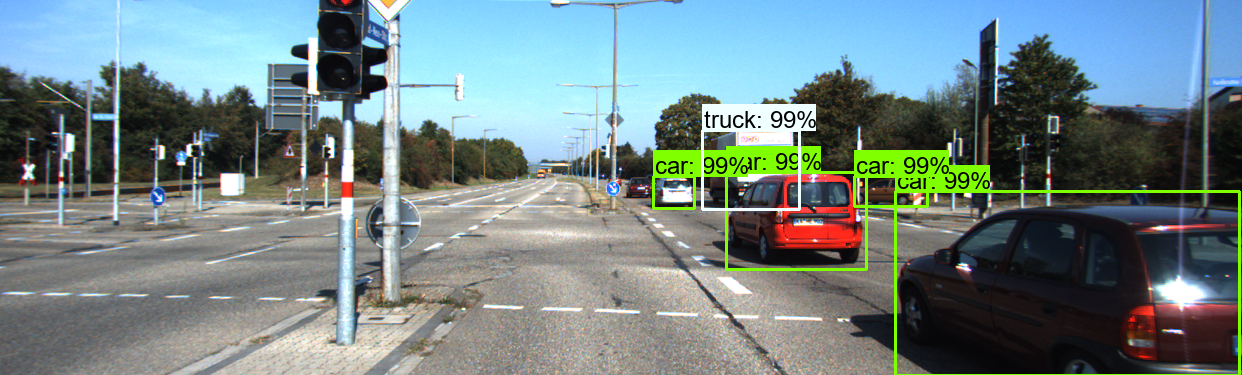

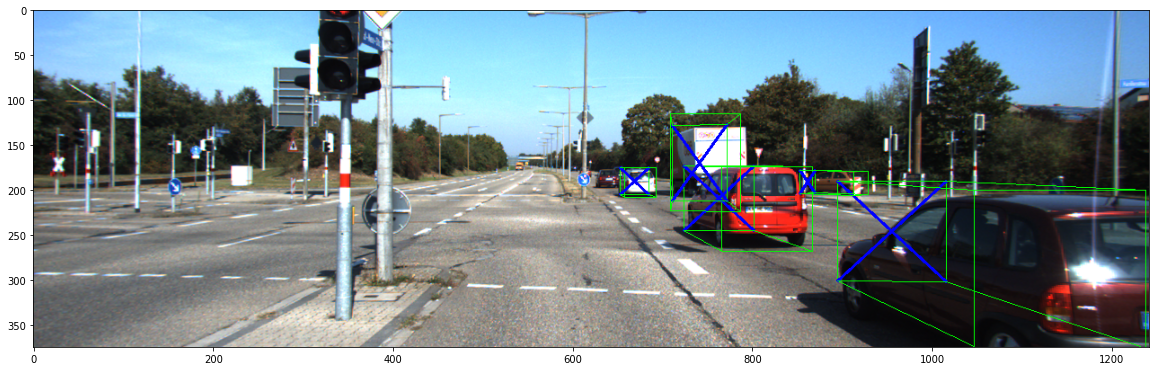

In [25]:
image = r"C:\Users\gtoun\Desktop\3d bounding box\test_images\0000000100.png"
calib = r"C:\Users\gtoun\Desktop\3d bounding box\test_images\calib_cam_to_cam.txt"
pred = Utils.get_2D_detection(model_2d,image)
Utils.show_2d_inference(model_2d, image)
Utils.visualize_final_3D(model,image,calib,pred)

## Testing on video

In [6]:
model_2d = Utils.load_2D_model(r"C:\Users\gtoun\Desktop\3d bounding box\2d_model\saved_model")
model_3d = build_model(input_shape = (224, 224, 3), weights = 'imagenet', freeze=True, feature_extractor=FEATURE_EXTRACTOR_3D)
model_3d.load_weights(r'C:\Users\gtoun\Desktop\3d bounding box\3d_model\saved_model')

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [14]:
video_dir = r'D:\2011_09_26\2011_09_26_drive_0005_sync\image_02\data'
calib_path = r'D:\2011_09_26\calib_cam_to_cam.txt'
output_path = r'C:\Users\gtoun\Desktop\3d bounding box\videos\0001.mp4'

w, h = 1242,375
fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
writer = cv2.VideoWriter(output_path, fourcc, 30, (w, h))

for root,_,names in os.walk(image_dir):
    names = sorted(names)
    for name in tqdm(names):
        if ".ini" not in name:
            image_path = os.path.join(root,name)
            pred = Utils.get_2D_detection(model_2d,image_path)
            frame = Utils.write_final_3D(model_3d, image_path, calib_path, pred, '')
            writer.write(frame)
writer.release()

['000003.png', '000012.png', '000016.png', '000018.png', '000027.png', '000035.png', '000040.png', '000041.png', '000048.png', '000053.png', '000062.png', '000067.png', '000068.png', '000072.png', '000073.png', '000076.png', '000077.png', '000089.png', '000093.png', '000102.png', '000103.png', '000107.png', '000111.png', '000124.png', '000146.png', '000147.png', '000151.png', '000152.png', '000153.png', '000154.png', '000161.png', '000162.png', '000163.png', '000164.png', '000166.png', '000169.png', '000170.png', '000188.png', '000192.png', '000203.png', '000204.png', '000206.png', '000208.png', '000209.png', '000212.png', '000214.png', '000217.png', '000221.png', '000228.png', '000229.png', '000230.png', '000233.png', '000235.png', '000245.png', '000247.png', '000248.png', '000253.png', '000254.png', '000266.png', '000272.png', '000275.png', '000284.png', '000290.png', '000296.png', '000301.png', '000304.png', '000306.png', '000307.png', '000311.png', '000313.png', '000345.png', '0003

  1%|▋                                                                             | 13/1596 [00:45<1:32:05,  3.49s/it]


KeyboardInterrupt: 